# Computer Vision - Fast Nearest Neighbors Algorithms

Author: `Vladislav Belov`

Date: `2020-03-25`
___

## Preparation of the Environment and Testing of PyFLANN

This section is dedicated to basic needs for reproducibility of results. Here we set up the Anaconda environment (note that the following code is functional also for standard Python installations; however, usage of virtual environments is recommended). We also test the functionality of PyFLANN by construction of a k-NN graph for synthetic data.

In [ ]:
# Installations (assuming that the notebook has been started under a fresh Anaconda virtual environment)
!conda install pip
!pip install 2to3 numpy pyflann scipy matplotlib networkx scikit-learn seaborn pandas

In [ ]:
# PyFLANN is a Python 2 package. We use Python 3.8.2; therefore, the package needs to be translated into Python 3.
# Following lines of code provide one with the path to Python packages folder.
# Use your path to PyFLANN library to translate it into Python 3.

# from distutils.sysconfig import get_python_lib
# print(get_python_lib())

!2to3 -w /Users/salisare-sama/opt/anaconda3/envs/computer-vision/lib/python3.8/site-packages/pyflann

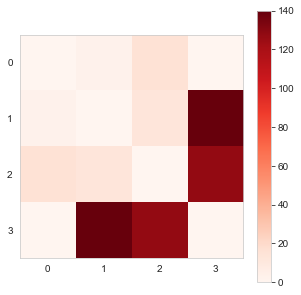

In [14]:
# Test PyFLANN by construction of a simple k-NN graph on synthetic data
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
from pyflann import *


params = {
    'kdtree': {
        'algorithm': 'kdtree',
        'target_precision': .95,
        'trees': 32
    },
    'kmeans': {
        'algorithm': 'kmeans',
        'branching': 32,
        'iterations': 10,
        'target_precision': .95
    }
}
data = np.array([
    [-1., -1.],
    [1., 1.], 
    [10., 10.], 
    [100., 100.]
])

flann = FLANN()
neighbors, distances = flann.nn(
    data, data, num_neighbors=3, **params['kmeans'])

knn_graph = csr_matrix((np.sqrt(distances.ravel()), 
                        (
                            np.repeat(np.arange(neighbors.shape[0]), 
                                      repeats=neighbors.shape[1]).astype(np.int), 
                            neighbors.ravel().astype(np.int)
                        )
                       ))

# Plot the adjacency matrix
G = nx.from_numpy_array(knn_graph.toarray())
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pos = ax.imshow(nx.adjacency_matrix(G).toarray(), cmap='Reds', interpolation='none')
fig.colorbar(pos, ax=ax)
ax.set_xticks(np.arange(knn_graph.shape[1], dtype=np.int))
ax.set_yticks(np.arange(knn_graph.shape[0], dtype=np.int))
ax.grid(which='major')
plt.show()

## Data Download

The following data are only relevant for the course.

In [ ]:
# Create directories to store data
from pathlib import Path

path = Path('./data/Oxford5K/').resolve()
path.mkdir(parents=True, exist_ok=True)
path = Path('./data/SIFT/').resolve()
path.mkdir(parents=True, exist_ok=True)

# Download raw data
!curl http://cmp.felk.cvut.cz/\~chum/XEP33SAM/imagenames.txt --output data/Oxford5K/imagenames.txt
!curl http://cmp.felk.cvut.cz/\~chum/XEP33SAM/imagedesc.dat --output data/Oxford5K/imagedesc.dat
!curl http://cmp.felk.cvut.cz/\~chum/XEP33SAM/images.zip --output data/Oxford5K/images.zip
!curl http://cmp.felk.cvut.cz/\~chum/XEP33SAM/sift.zip --output data/SIFT/sift.zip
!tar -xf data/Oxford5K/images.zip -C data/Oxford5K/
!tar -xf data/SIFT/sift.zip -C data/SIFT/

## Custom $k$-means Implementation

#### The Implementation

Vectors representing initial cluster centers are hard-coded using sampling from the uniform distribution $U(\alpha, \beta)$ where $\alpha$ and $\beta$ are given by values in the data set (minimum and maximum, respectively). This is only one of many solutions - more optimal ones are available, e.g. $k$-means++.


#### Test of the Implementation

To test the implementation, we apply `CustomKMeans` on randomly generated blobs and plot results.


Iteration 20: no progress during last 10 iterations

Evaluation time per iteration:
	AVG. = 0.0006211400032043457s
	STD. = 0.0004589798446733291s
Assignment time per iteration:
	AVG. = 8.585055669148763e-05s
	STD. = 0.00028473408458879954s


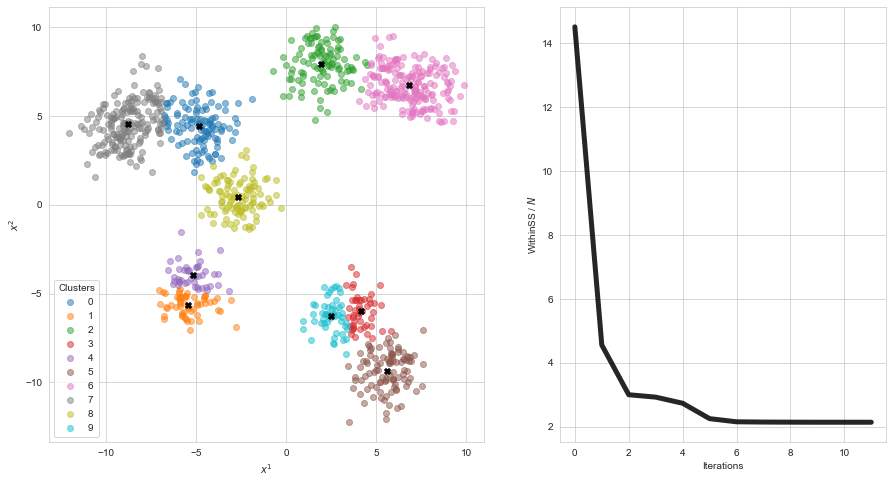

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from pylib.ann.cluster import CustomKMeans


# Generate random data
np.random.seed(17)
N_CENTERS = 10
N_SAMPLES = 1000
DIM = 2
data, _ = make_blobs(
    n_samples=N_SAMPLES, 
    centers=N_CENTERS, 
    n_features=DIM,
    random_state=20
)
# data = np.random.random((N_SAMPLES, DIM)).astype(np.float32)

# Fit using CustomKMeans
km = CustomKMeans(
    n_centers=N_CENTERS, 
    method='kmeans',
    nn_autotune=-1,
    apply_fix=True,
    verbose=False
)
km.fit(data)
print(km.time_report())
centers = km.centers_
labels = km.labels_
measure = km.stats_['measure']

# Plot results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8),
                              gridspec_kw={'width_ratios': (2, 1.5)})
for label in range(N_CENTERS):
    idx = np.where(labels == label)[0]
    ax1.scatter(data[idx, 0], data[idx, 1], label=label, alpha=.5)
    ax1.scatter(centers[label, 0], centers[label, 1], marker='X', s=35, color='k')
ax1.set_xlabel(r'$x^{1}$')
ax1.set_ylabel(r'$x^{2}$')
ax1.legend(loc='best', title='Clusters')
ax2.plot(np.arange(len(measure)), measure, color='k', linewidth=5., alpha=.85)
ax2.set_xlabel('Iterations')
ax2.set_ylabel(r'WithinSS / $N$')
ax1.grid(True)
ax2.grid(True)
fig.savefig('./images/flann/kmeans_test.png')
plt.show()

#### Application of `CustomKMeans` on your data

Change parameters and import data in **flann.py** and run the following script from the core directory (__computer-vision__/):

In [ ]:
!python flann.py

## Comparison of NN Approaches in the Approximate $k$-means Framework

Code for the figures which will be added to the report.

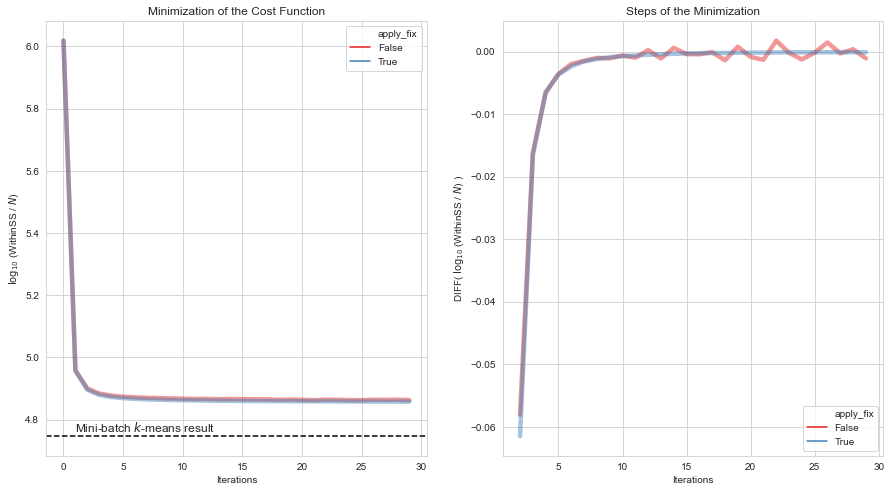

In [33]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")


margin = np.log10(55864.63)

# # Read the data 1
# files = glob.glob('./data/*id_1*.csv')
# df1 = pd.concat(
#     [pd.read_csv(file) for file in files]
# )
# df1 = df1.fillna('')
# df1.loc[:, 'measure'] = np.log10(df1.loc[:, 'measure'])
# df1.loc[:, 'index'] += 1
# # Read data 2
# files = glob.glob('./data/*id_2*.csv')
# df2 = pd.concat(
#     [pd.read_csv(file) for file in files]
# )
# df2 = df2.fillna('')
# df2.loc[:, 'measure'] = np.log10(df2.loc[:, 'measure'])
# df2.loc[:, 'index'] += 1
# Read data

# # Plot
# order = sorted(pd.unique(df1['algorithm']))
# fig, (ax1, ax2) = plt.subplots(
#     nrows=1, ncols=2, figsize=(15, 8)
# #     gridspec_kw={'width_ratios': (2, 1.5)}
# )
# sns.lineplot(x='index', y='measure', 
#              hue='algorithm', style='algorithm', 
#              alpha=.45,
#              hue_order=order,
#              style_order=order,
#              linewidth=4.5,
#              ax=ax1, 
#              data=df1)
# ax1.axhline(margin, color='k', linestyle='--')
# ax1.text(1., margin + .015, 
#          'Mini-batch $k$-means result', 
#          fontsize=12)
# ax1.set_xlabel('Iterations')
# ax1.set_ylabel(r'$\log_{10}$ (WithinSS / $N$)')
# ax1.set_title('ID = 1')
# sns.lineplot(x='index', y='measure', 
#              hue='algorithm', style='algorithm', 
#              alpha=.45,
#              hue_order=order,
#              style_order=order,
#              linewidth=4.5,
#              ax=ax2, 
#              data=df2)
# ax2.axhline(margin, color='k', linestyle='--')
# ax2.text(1., margin + .015, 
#          'Mini-batch $k$-means result', 
#          fontsize=12)
# ax2.set_xlabel('Iterations')
# ax2.set_ylabel(r'$\log_{10}$ (WithinSS / $N$)')
# ax2.set_title('ID = 2')
# fig.savefig('./images/flann/comparison.png')
# # fig.tight_layout()
# plt.show()

# Read the data with 'apply_fix' introduction
files = glob.glob('./data/*fix*.csv')
df = pd.concat(
    [pd.read_csv(file) for file in files]
)
df.index = np.arange(df.shape[0])
df.loc[:, 'measure'] = np.log10(df.loc[:, 'measure'])
df.loc[:, 'diff'] = df.groupby('apply_fix')['measure'].diff()

# Plot
order = sorted(pd.unique(df['apply_fix']))
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(15, 8)
#     gridspec_kw={'width_ratios': (2, 1.5)}
)
sns.lineplot(x='index', y='measure', 
             hue='apply_fix',
             palette='Set1',
             alpha=.45,
             hue_order=order,
             linewidth=4.5,
             ax=ax1, 
             data=df)
ax1.axhline(margin, color='k', linestyle='--')
ax1.text(1., margin + .015, 
         'Mini-batch $k$-means result', 
         fontsize=12)
ax1.set_xlabel('Iterations')
ax1.set_ylabel(r'$\log_{10}$ (WithinSS / $N$)')
ax1.set_title('Minimization of the Cost Function')
sns.lineplot(x='index', y='diff', 
             hue='apply_fix',
             palette='Set1',
             alpha=.45,
             hue_order=order,
             linewidth=4.5,
             ax=ax2, 
             data=df[df['index'] > 1])
ax2.set_xlabel('Iterations')
ax2.set_ylabel(r'DIFF( $\log_{10}$ (WithinSS / $N$) )')
ax2.set_title('Steps of the Minimization')
fig.savefig('./images/flann/comparison_fix.png')
plt.show()